In [1]:
# dask
import dask
from dask.distributed import Client
from dask.distributed import deploy
from dask_jobqueue import PBSCluster
import dask
from data_loading import multiframe_tiff
from data_masking import mask_creation
from utils import util

# standard lib
from pathlib import Path
import io

# image processing
from PIL import Image

# numerical libraries
import numpy

In [2]:
cluster = deploy.local.LocalCluster(n_workers=2)

In [ ]:
cluster = 

In [3]:
client = Client(cluster)

In [4]:
path = "/home/sanderth/images"
images = multiframe_tiff.from_directory(path)

In [5]:
images = mask_creation.create_masks(images)

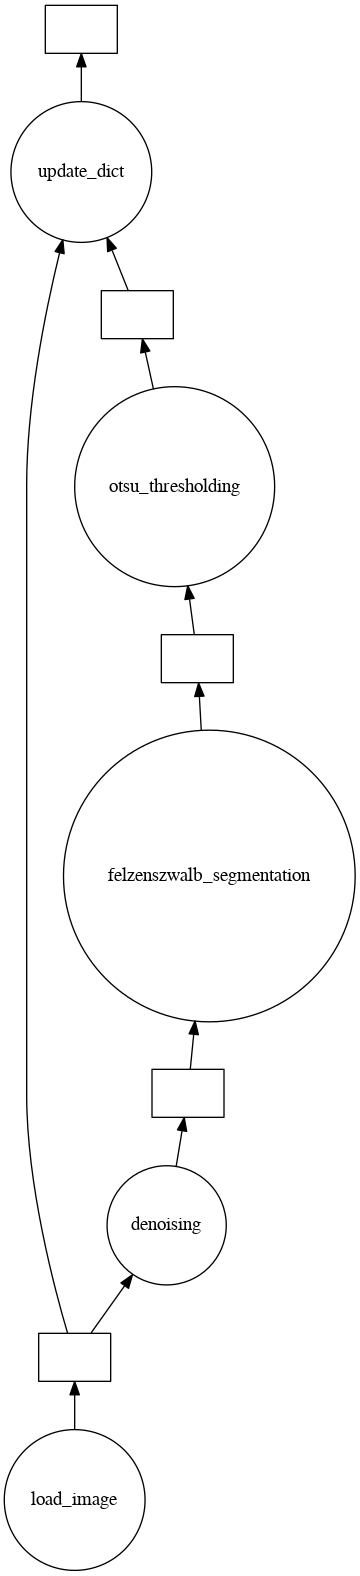

In [6]:
images[0].visualize()

In [7]:
a = dict(b=1, c=2)

In [8]:
test = a.update(f=3)

In [9]:
test

In [ ]:
%%time
images = dask.compute(*images)


In [11]:
print(images)

({'pixels': array([[[ 1.42701149e-01,  1.38496667e-01,  1.43769860e-01, ...,
          1.41048923e-01,  1.34646326e-01,  1.36154130e-01],
        [ 1.40572354e-01,  1.39076635e-01,  1.46103308e-01, ...,
          1.41493127e-01,  1.35261491e-01,  1.37983069e-01],
        [ 1.40155479e-01,  1.41411483e-01,  1.42238289e-01, ...,
          1.38079986e-01,  1.44098774e-01,  1.41128004e-01],
        ...,
        [ 1.37699619e-01,  1.32166862e-01,  1.42797321e-01, ...,
          1.36460111e-01,  1.48520246e-01,  1.33239880e-01],
        [ 1.38992459e-01,  1.36591569e-01,  1.36796921e-01, ...,
          1.36016369e-01,  1.48854449e-01,  1.33674607e-01],
        [ 1.41230568e-01,  1.39397919e-01,  1.38505280e-01, ...,
          1.31564245e-01,  1.47552431e-01,  1.32360026e-01]],

       [[ 5.01571642e-03, -8.64215617e-05,  2.68548820e-03, ...,
         -7.31566513e-04,  2.33274931e-03, -2.07089074e-03],
        [ 6.74302550e-03,  1.66845377e-04,  3.04002315e-03, ...,
          8.34919265e-05, 

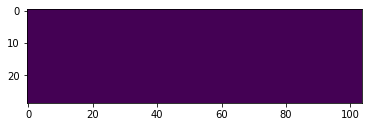

In [17]:
import matplotlib.pyplot as plt
plt.imshow(images[0]['mask'][0])

In [4]:
@dask.delayed
def load_multiframe_tiff(p):
    im = Image.open(p)
    arr = numpy.empty(shape=(im.n_frames, im.height, im.width), dtype=float)
    for i in range(im.n_frames):
        im.seek(i)
        arr[i] = numpy.array(im)
    return arr

In [6]:
images = []
for p in Path("/home/sanderth/debug_images").glob("*.tiff"):
    images.append(load_multiframe_tiff(str(p)))

In [ ]:
from skimage import img_as_float, img_as_uint, filters, exposure, morphology, segmentation, measure
from skimage.restoration import denoise_nl_means
import numpy as np
from PIL import Image

In [ ]:
def denoised_felzenszwalb_otsu_mask(im):

    data = np.array(im)
    mask = np.empty(data.shape, dtype=bool)
    channels = data.shape[0]

    for i in range(channels):
            img = np.array(data[i])

            # Non-local mean denoising
            if i not in noisy_channels:
                img = denoise_nl_means(np.array(img), multichannel=False, patch_size=nlm_psize,
                                     patch_distance=nlm_pdist, fast_mode=True)


            # Felzenszwalb segmentation
            segment_fz = segmentation.felzenszwalb(img, sigma=fz_sigma, scale=fz_scale)

            # Avoid threshold calculation on low signals
            if len(np.unique(segment_fz)) <= 1:
                mask[i] = segment_fz
                continue

            # Calculation of Otsu threshold
            threshold = filters.threshold_otsu(segment_fz)

            # Convertion to Boolean mask with Otsu threshold
            mask_denoized = segment_fz > threshold

            mask[i] = mask_denoized

    return mask.tolist()

In [7]:
%time
pixels = dask.compute(*images)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [12]:
client.close()
cluster.close()